In [1]:
import torch
import lightning as L
import torchvision.utils as utils
import matplotlib.pyplot as plt
from dcgan import DCGAN
from vae import VAE
from diffusion import Diffusion
from gan import GAN
from cycle_gan import CycleGAN

L.seed_everything(42)
torch.set_float32_matmul_precision("high")

/home/dxzielinski/Desktop/github-repositories/dl-generative/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


# Latent space interpolation

## DCGAN

In [3]:
checkpoint_path = "../checkpoints/dcgan/dcgan-transforms-epoch=443-d_loss=0.01-g_loss=4.86-fid_score=31.61.ckpt"
lightning_checkpoint = torch.load(
    checkpoint_path,
    map_location=lambda storage, loc: storage,
)
hyperparams = lightning_checkpoint["hyper_parameters"]
hyperparams.pop("lr", None)
model = DCGAN.load_from_checkpoint(
    checkpoint_path,
    **hyperparams,
)

In [4]:
num_steps = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z1 = torch.randn(1, hyperparams["latent_dim"], device=device)
z2 = torch.randn(1, hyperparams["latent_dim"], device=device)
alphas = torch.linspace(0, 1, steps=num_steps, device=device).unsqueeze(1)
zs = (1 - alphas) * z1 + alphas * z2

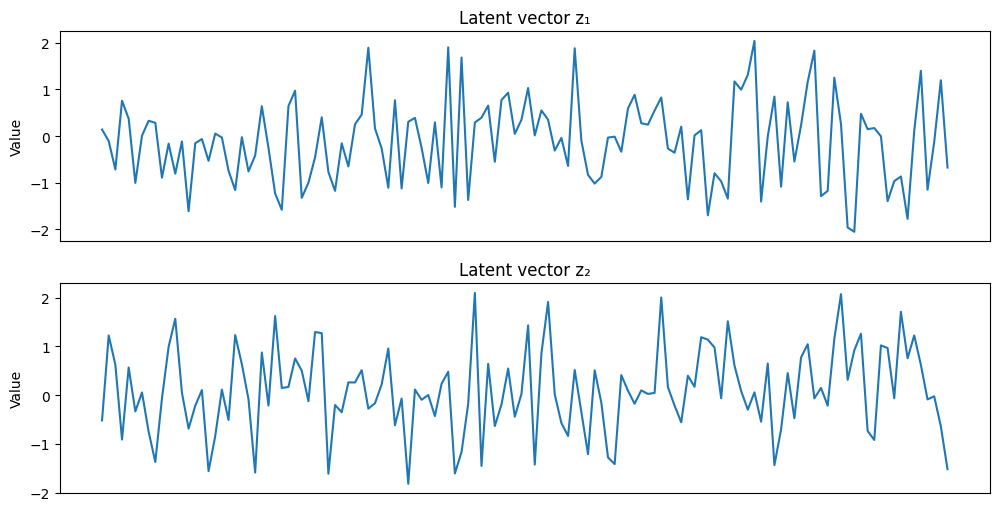

In [4]:
fig, axes = plt.subplots(
    2,
    1,
    figsize=(num_steps * 1.2, 6),
)
axes[0].plot(z1.cpu().squeeze().numpy())
axes[0].set_title("Latent vector z₁")
axes[0].set_ylabel("Value")
axes[0].set_xticks([])
axes[1].plot(z2.cpu().squeeze().numpy())
axes[1].set_title("Latent vector z₂")
axes[1].set_ylabel("Value")
axes[1].set_xticks([])
plt.show()

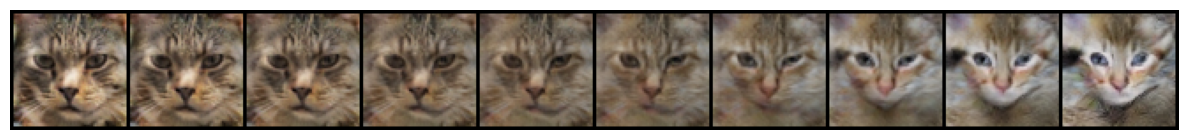

In [5]:
model = model.to(device).eval()
with torch.no_grad():
    imgs = model.generator(zs)
    imgs = (imgs + 1) / 2
    imgs = torch.clamp(imgs, 0, 1)
grid = utils.make_grid(imgs, nrow=num_steps, padding=2)
np_grid = grid.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(num_steps * 1.5, 1.5))
plt.axis("off")
plt.imshow(np_grid)
plt.tight_layout()
plt.show()

## GAN

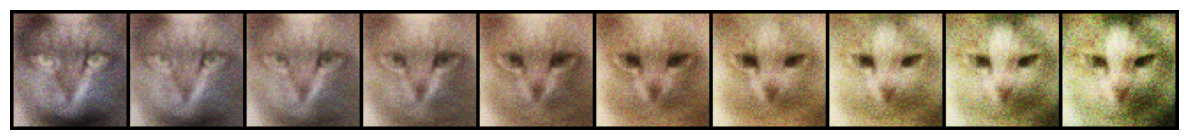

In [6]:
checkpoint_path = "../checkpoints/gan/gan-transforms-epoch=137-d_loss=0.43-g_loss=1.46-fid_score=123.88.ckpt"
lightning_checkpoint = torch.load(
    checkpoint_path,
    map_location=lambda storage, loc: storage,
)
hyperparams = lightning_checkpoint["hyper_parameters"]
hyperparams.pop("lr", None)
model = GAN.load_from_checkpoint(
    checkpoint_path,
    **hyperparams,
)
model = model.to(device).eval()
with torch.no_grad():
    imgs = model.generator(zs)
    imgs = (imgs + 1) / 2
    imgs = torch.clamp(imgs, 0, 1)
grid = utils.make_grid(imgs, nrow=num_steps, padding=2)
np_grid = grid.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(num_steps * 1.5, 1.5))
plt.axis("off")
plt.imshow(np_grid)
plt.tight_layout()
plt.show()

## VAE

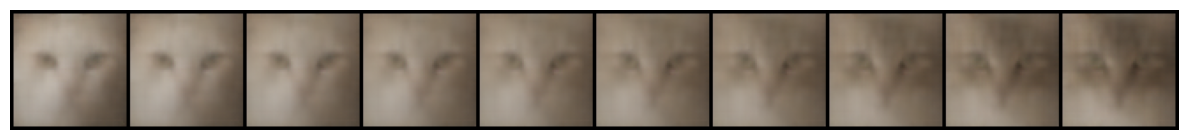

In [18]:
checkpoint_path = "../checkpoints/vae/vae-epoch=49-fid_score=160.62.ckpt"
lightning_checkpoint = torch.load(
    checkpoint_path,
    map_location=lambda storage, loc: storage,
)
hyperparams = lightning_checkpoint["hyper_parameters"]
hyperparams.pop("lr", None)
model = VAE.load_from_checkpoint(
    checkpoint_path,
    **hyperparams,
)
model = model.to(device).eval()
with torch.no_grad():
    imgs = model.decoder(zs)
    imgs = (imgs + 1) / 2
    imgs = torch.clamp(imgs, 0, 1)
grid = utils.make_grid(imgs, nrow=num_steps, padding=2)
np_grid = grid.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(num_steps * 1.5, 1.5))
plt.axis("off")
plt.imshow(np_grid)
plt.tight_layout()
plt.show()

# Dogs vs Cats dataset

## DCGAN

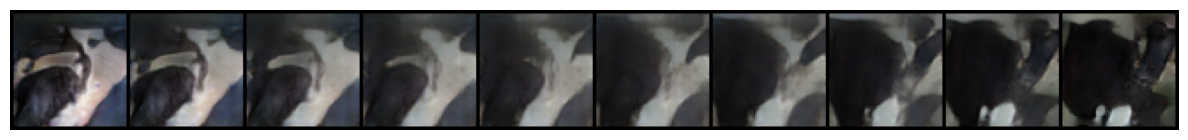

In [9]:
checkpoint_path = "../checkpoints/dcgan-dogscats/dcgan-transforms-dogscats-epoch=476-fid_score=103.44.ckpt"
lightning_checkpoint = torch.load(
    checkpoint_path,
    map_location=lambda storage, loc: storage,
)
hyperparams = lightning_checkpoint["hyper_parameters"]
hyperparams.pop("lr", None)
model = DCGAN.load_from_checkpoint(
    checkpoint_path,
    **hyperparams,
)
model = model.to(device).eval()
with torch.no_grad():
    imgs = model.generator(zs)
    imgs = (imgs + 1) / 2
    imgs = torch.clamp(imgs, 0, 1)
grid = utils.make_grid(imgs, nrow=num_steps, padding=2)
np_grid = grid.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(num_steps * 1.5, 1.5))
plt.axis("off")
plt.imshow(np_grid)
plt.tight_layout()
plt.show()

## CycleGAN

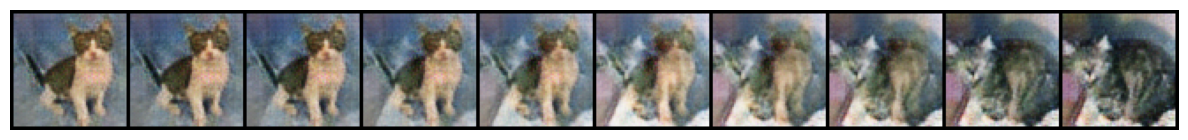

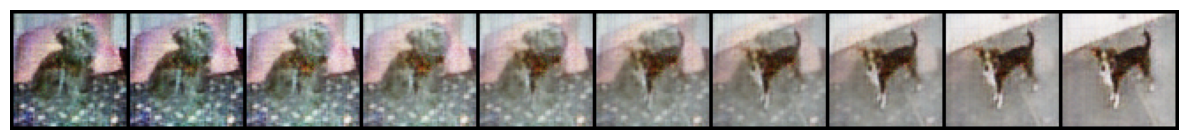

In [ ]:
import torchvision.utils as vutils
from torchvision import transforms
from PIL import Image
import numpy as np

ckpt_path = "../checkpoints/cycle-gan/cycle-gan-epoch=16-fid_score=99.00.ckpt"
ckpt = torch.load(ckpt_path, map_location="cpu")
hparams = ckpt["hyper_parameters"]
model = CycleGAN.load_from_checkpoint(ckpt_path, **hparams)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

prep = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3),
    ]
)
imgA1 = prep(
    Image.open(
        "/home/dxzielinski/Downloads/dogs-vs-cats-cycle/train/cat/cat.12433.jpg"
    ).convert("RGB")
).to(device)
imgA2 = prep(
    Image.open(
        "/home/dxzielinski/Downloads/dogs-vs-cats-cycle/train/cat/cat.10239.jpg"
    ).convert("RGB")
).to(device)

num_steps = 10
alphas = np.linspace(0, 1, num_steps)
interpolations = [(1 - alpha) * imgA1 + alpha * imgA2 for alpha in alphas]

with torch.no_grad():
    fakeBs = [model.netG_A2B(img.unsqueeze(0)).cpu() for img in interpolations]
    fakeBs = [(fb + 1) / 2 for fb in fakeBs]

grid = vutils.make_grid(torch.cat(fakeBs, dim=0), nrow=num_steps, padding=2)
np_img = grid.permute(1, 2, 0).numpy()
plt.figure(figsize=(num_steps * 1.2, 1.5))
plt.axis("off")
plt.imshow(np_img)
plt.tight_layout()
plt.show()
imgB1 = prep(
    Image.open(
        "/home/dxzielinski/Downloads/dogs-vs-cats-cycle/train/dog/dog.0.jpg"
    ).convert("RGB")
).to(device)
imgB2 = prep(
    Image.open(
        "/home/dxzielinski/Downloads/dogs-vs-cats-cycle/train/dog/dog.12490.jpg"
    ).convert("RGB")
).to(device)

alphas = np.linspace(0, 1, num_steps)
interp_B = [(1 - alpha) * imgB1 + alpha * imgB2 for alpha in alphas]

with torch.no_grad():
    fakeAs = [model.netG_B2A(img.unsqueeze(0)).cpu() for img in interp_B]
    fakeAs = [(fa + 1) / 2 for fa in fakeAs]

gridB = vutils.make_grid(torch.cat(fakeAs, dim=0), nrow=num_steps, padding=2)
np_gridB = gridB.permute(1, 2, 0).numpy()
plt.figure(figsize=(num_steps * 1.2, 1.5))
plt.axis("off")
plt.imshow(np_gridB)
plt.tight_layout()
plt.show()